In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from fastcore.xtras import load_pickle
from guacamol.utils.chemistry import is_valid

from gptchem.data import get_photoswitch_data
from gptchem.evaluator import evaluate_generated_smiles, evaluate_photoswitch_smiles_pred
from gptchem.settings import ONE_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_WIDTH_INCH

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])

import matplotx

%matplotlib inline

In [23]:
from rdkit import Chem

In [24]:
all_res = glob("out/**/*.pkl")

In [25]:
res = load_pickle(all_res[0])

In [26]:
from collections import defaultdict

In [27]:
def contains_azo(smiles):
    mol = Chem.MolFromSmiles(smiles)
    # check if there is a N#N bond
    smarts = "[NX2]=N"
    return mol.HasSubstructMatch(Chem.MolFromSmarts(smarts))

In [28]:
compiled_res = []
generated_smiles = set()
generated_smiles_w_azos = set()

generated_smiles_w_azos_at_temp = defaultdict(set)
generated_smiles_at_temp = defaultdict(set)

for res_path in all_res:
    res = load_pickle(res_path)
    for temp_res in res["res_at_temp"]:

        metrics = {
            "noise_level": res["noise_level"],
            "temp": temp_res["temperature"],
            "frac_valid": temp_res["frac_valid"],
            "frac_unique": temp_res["frac_unique"],
            "frac_smiles_in_train": temp_res["frac_smiles_in_train"],
            "frac_smiles_in_pubchem": temp_res["frac_smiles_in_pubchem"],
            "kld": temp_res["kld"],
            "frechet_d": temp_res["frechet_d"],
            "frechet_score": temp_res["frechet_score"],
            "frac_contains_azo": sum([contains_azo(s) for s in temp_res["valid_smiles"]])
            / len(temp_res["valid_smiles"]),
        }

        generated_smiles.update([s for s in temp_res["generated_smiles"] if is_valid(s)])
        v_w_azo = [s for s in temp_res["generated_smiles"] if is_valid(s) and contains_azo(s)]
        generated_smiles_w_azos.update(v_w_azo)
        generated_smiles_w_azos_at_temp[temp_res["temperature"]].update(v_w_azo)

        v = [s for s in temp_res["generated_smiles"] if is_valid(s)]
        generated_smiles_at_temp[temp_res["temperature"]].update(v)

        for me, v in temp_res["e_pi_pi_star_metrics"].items():
            metrics["e_pi_pi_star_" + me] = v

        for me, v in temp_res["z_pi_pi_star_metrics"].items():
            metrics["z_pi_pi_star_" + me] = v
        compiled_res.append(metrics)

In [29]:
contains_azo(list(generated_smiles)[5])

True

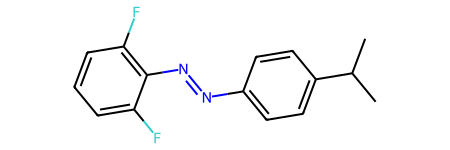

In [30]:
Chem.MolFromSmiles(list(generated_smiles)[0])

In [31]:
df = pd.DataFrame(compiled_res)

In [32]:
grouped = df.groupby(["temp"]).agg(["mean", "std"])

In [33]:
grouped

noise_level            frac_valid           frac_unique            \
            mean        std       mean       std        mean       std   
temp                                                                     
0.00    7.535714  13.471429   0.984472  0.049484    0.037625  0.024498   
0.10    7.535714  13.471429   0.979814  0.035378    0.066538  0.038213   
0.20    7.535714  13.471429   0.969720  0.036471    0.124788  0.042943   
0.50    7.535714  13.471429   0.967391  0.017054    0.385304  0.044582   
0.75    7.535714  13.471429   0.904503  0.038883    0.568468  0.032718   
1.00    7.535714  13.471429   0.692547  0.041866    0.766746  0.059218   
1.25    7.535714  13.471429   0.328416  0.051546    0.914046  0.059036   
1.50    7.535714  13.471429   0.117236  0.038175    1.000000  0.000000   
2.00    7.535714  13.471429   0.122671  0.032866    1.000000  0.000000   

     frac_smiles_in_train      frac_smiles_in_pubchem            ...  \
                     mean  std                   mean       std  ...   
temp                                                             ...   
0.00                  0.0  0.0               1.000000  0.000000  ...   
0.10                  0.0  0.0               1.000000  0.000000  ...   
0.20                  0.0  0.0               1.000000  0.000000  ...   
0.50                  0.0  0.0               1.000000  0.000000  ...   
0.75                  0.0  0.0               1.000000  0.000000  ...   
1.00                  0.0  0.0               1.000000  0.000000  ...   
1.25                  0.0  0.0               1.000000  0.000000  ...   
1.50                  0.0  0.0               1.000000  0.000000  ...   
2.00                  0.0  0.0               0.982143  0.048245  ...   

     z_pi_pi_star_r2           z_pi_pi_star_max_error             \
                mean       std                   mean        std   
temp                                                               
0.00       -0.037679  0.060345              59.526601  18.816509   
0.10       -0.038522  0.048937              60.562075  20.900530   
0.20       -0.078712  0.070868              60.843421  18.661915   
0.50       -0.160328  0.103254              69.117157  19.693271   
0.75       -0.207305  0.165349              70.875514  18.147049   
1.00       -0.359064  0.212447              72.581737  20.762474   
1.25       -0.557804  0.421038              58.391206  19.729582   
1.50       -3.092728  4.381971              64.084847  27.629959   
2.00       -4.978061  3.794202              65.277043  11.142901   

     z_pi_pi_star_mean_absolute_error             \
                                 mean        std   
temp                                               
0.00                        16.343790   6.596106   
0.10                        16.401549   6.445510   
0.20                        16.822664   7.042204   
0.50                        17.213116   6.639180   
0.75                        16.908892   6.107023   
1.00                        18.088610   6.842745   
1.25                        18.265983   7.340953   
1.50                        30.245796  15.414255   
2.00                        33.144496   3.568013   

     z_pi_pi_star_mean_squared_error              z_pi_pi_star_rmse             
                                mean          std              mean        std  
temp                                                                            
0.00                      535.386764   529.582011         21.694255   8.350241  
0.10                      536.461202   528.742584         21.761269   8.230887  
0.20                      565.372999   569.315968         22.238958   8.732011  
0.50                      593.237797   551.153916         23.000874   8.314797  
0.75                      581.866055   503.540004         22.918137   7.809022  
1.00                      666.682300   593.120796         24.440258   8.642405  
1.25                      650.849409   653.969846         23.923318   9.195902  

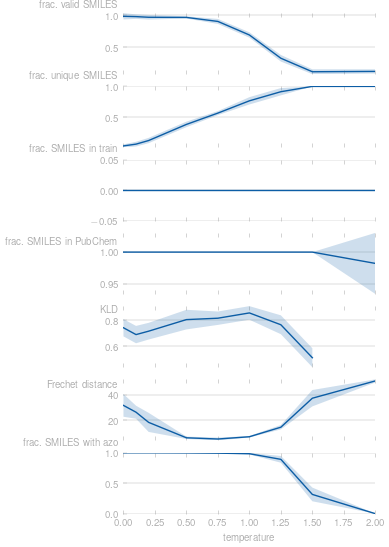

In [34]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(7, 1, sharex="all", figsize=(ONE_COL_WIDTH_INCH, 2 * ONE_COL_WIDTH_INCH))
    ax[0].plot(grouped.index, grouped["frac_valid"]["mean"], label="frac_valid")
    ax[0].fill_between(
        grouped.index,
        grouped["frac_valid"]["mean"] - grouped["frac_valid"]["std"],
        grouped["frac_valid"]["mean"] + grouped["frac_valid"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. valid SMILES", ax=ax[0])

    ax[1].plot(grouped.index, grouped["frac_unique"]["mean"], label="frac_unique")
    ax[1].fill_between(
        grouped.index,
        grouped["frac_unique"]["mean"] - grouped["frac_unique"]["std"],
        grouped["frac_unique"]["mean"] + grouped["frac_unique"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. unique SMILES", ax=ax[1])

    ax[2].plot(grouped.index, grouped["frac_smiles_in_train"]["mean"], label="frac_smiles_in_train")
    ax[2].fill_between(
        grouped.index,
        grouped["frac_smiles_in_train"]["mean"] - grouped["frac_smiles_in_train"]["std"],
        grouped["frac_smiles_in_train"]["mean"] + grouped["frac_smiles_in_train"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. SMILES in train", ax=ax[2])

    ax[3].plot(
        grouped.index, grouped["frac_smiles_in_pubchem"]["mean"], label="frac_smiles_in_pubchem"
    )
    ax[3].fill_between(
        grouped.index,
        grouped["frac_smiles_in_pubchem"]["mean"] - grouped["frac_smiles_in_pubchem"]["std"],
        grouped["frac_smiles_in_pubchem"]["mean"] + grouped["frac_smiles_in_pubchem"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. SMILES in PubChem", ax=ax[3])

    ax[4].plot(grouped.index, grouped["kld"]["mean"], label="kld")
    ax[4].fill_between(
        grouped.index,
        grouped["kld"]["mean"] - grouped["kld"]["std"],
        grouped["kld"]["mean"] + grouped["kld"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("KLD", ax=ax[4])

    ax[5].plot(grouped.index, grouped["frechet_d"]["mean"], label="frechet_d")
    ax[5].fill_between(
        grouped.index,
        grouped["frechet_d"]["mean"] - grouped["frechet_d"]["std"],
        grouped["frechet_d"]["mean"] + grouped["frechet_d"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("Frechet distance", ax=ax[5])

    ax[6].plot(grouped.index, grouped["frac_contains_azo"]["mean"], label="frechet_score")
    ax[6].fill_between(
        grouped.index,
        grouped["frac_contains_azo"]["mean"] - grouped["frac_contains_azo"]["std"],
        grouped["frac_contains_azo"]["mean"] + grouped["frac_contains_azo"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. SMILES with azo", ax=ax[6])

    ax[-1].set_xlabel("temperature", labelpad=4)

    fig.savefig("photoswitch_random_smiles_metrics.pdf", bbox_inches="tight")

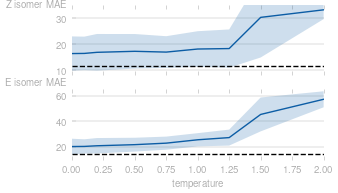

In [35]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(
        2, 1, sharex="all", figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH)
    )

    ax[0].plot(
        grouped.index,
        grouped["z_pi_pi_star_mean_absolute_error"]["mean"],
        label="e_pi_pi_star_metrics",
    )
    ax[0].fill_between(
        grouped.index,
        grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
        - grouped["z_pi_pi_star_mean_absolute_error"]["std"],
        grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
        + grouped["z_pi_pi_star_mean_absolute_error"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("Z isomer MAE", ax=ax[0])

    ax[0].hlines(11.616605626696359, 0, 2, color="k", linestyle="--")

    ax[0].set_ylim(8, 35)

    ax[1].plot(
        grouped.index,
        grouped["e_pi_pi_star_mean_absolute_error"]["mean"],
        label="e_pi_pi_star_metrics",
    )
    ax[1].fill_between(
        grouped.index,
        grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
        - grouped["e_pi_pi_star_mean_absolute_error"]["std"],
        grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
        + grouped["e_pi_pi_star_mean_absolute_error"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("E isomer MAE", ax=ax[1])

    ax[1].hlines(14.38998132190228, 0, 2, color="k", linestyle="--")

    ax[-1].set_xlabel("temperature", labelpad=4)
    ax[1].set_ylim(10, 65)
fig.savefig("random_photoswitch_constrain_matches.pdf", bbox_inches="tight")

## Visualize

In [36]:
import numpy as np
import tmap as tm
from faerun import Faerun
from mhfp.encoder import MHFPEncoder
from rdkit.Chem import AllChem
from tqdm import tqdm

In [37]:
import os
import shutil

In [38]:
def make_figure(temp):
    path = f"plots_all/{temp}"
    os.makedirs(path, exist_ok=True)
    enc = MHFPEncoder()
    lf = tm.LSHForest(2048, 128)
    train_data = get_photoswitch_data()
    train_smiles = train_data["SMILES"].values
    all_smiles = set(train_smiles) | generated_smiles_at_temp[temp]

    fps = []
    labels = []

    for smiles in tqdm(all_smiles):
        mol = AllChem.MolFromSmiles(smiles)
        fps.append(tm.VectorUint(enc.encode_mol(mol, min_radius=0)))
        labels.append(smiles in train_smiles)

    lf.batch_add(fps)
    lf.index()
    cfg = tm.LayoutConfiguration()
    cfg.k = 100
    cfg.sl_extra_scaling_steps = 6
    cfg.sl_repeats = 2
    cfg.mmm_repeats = 2
    cfg.node_size = 2
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, config=cfg)

    f = Faerun(
        clear_color="#FFFFFF",
        coords=False,
        view="free",
        impress='made with <a href="http://tmap.gdb.tools" target="_blank">tmap</a><br />and <a href="https://github.com/reymond-group/faerun-python" target="_blank">faerun</a>',
    )
    f.add_scatter(
        f"Photoswitches",
        {
            "x": x,
            "y": y,
            "c": labels,
            "labels": all_smiles,
        },
        colormap="Set1",
        categorical=True,
        shader="sphere",
        has_legend=True,
        point_scale=5,
        legend_labels=[(1, "in database"), (0, "not in database")],
        max_point_size=5000,
    )
    f.add_tree(
        "Photoswitches_tree",
        {
            "from": s,
            "to": t,
        },
        point_helper="Photoswitches",
    )
    f.plot("Photoswitches", template="smiles")

    shutil.copy("Photoswitches.html", path)

In [39]:
for temp in [0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]:
    make_figure(temp)

100%|██████████| 404/404 [00:05<00:00, 74.33it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 404/404 [00:07<00:00, 52.57it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 408/408 [00:06<00:00, 64.12it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 448/448 [00:06<00:00, 66.03it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 532/532 [00:08<00:00, 62.70it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 654/654 [00:09<00:00, 65.76it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 605/605 [00:05<00:00, 116.20it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 531/531 [00:04<00:00, 119.42it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 560/560 [00:04<00:00, 131.36it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

In [41]:
make_figure(1.5)

100%|██████████| 531/531 [00:04<00:00, 106.56it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html